# Universal Quantum Computing with Measurement-Induced Continuous-Variable Gate Sequence in a Loop-Based Architecture

- measurement-induced
- continuous-variable
- loop-based architecture
- time-bin-encoded information in a single spatial mode
- deterministically processed
- performed fault-tolerantly
- offers a universal gate set for both qubits and continuous variables

CVによる測定誘起量子計算はqubit方式より以下の点で優秀
- ancillae state と 測定(ホモダイン)を確率的でなくdeterministicに実行可能  

qubitにはrobust encodingというメリットがある。  
組み合わせて使いたい。

空間モードエンコードは結局コンポーネント数が多くなりすぎるのでアウト  
time-bin encodeをしよう

- 単一の空間モード中の n-pulses に量子状態をエンコード
- m個の ancilla pulses と一緒にループに入れる
- ゲート操作は電気的操作をスイッチ、BSの透過率、phase shifter, 増幅器ゲインに対し行って実現  


- 実験の複雑さを増すことなく、任意の入力、任意のモード数に対して行える
- 任意のマルチモードクリフォードゲートを決定的に作るためには、1個の ancilla (スクイーズリソース)と1個のホモダインディテクタ、feedfoward electronicsがあれば良い(効率的)
- Qubit, CV(qumode)双方に対してユニバーサル量子ゲートが実現可能。

誤り訂正符号も実装可能らしい...  
D. Gottesman, A. Kitaev, and J. Preskill, Phys. Rev. A 64, 012310 (2001)

CVにおいて、Clifford gates は Gaussian gates
$\hat{R}(θ_2) \hat{S}(r) \hat{R}(θ_1)$
と等価！  
$\hat{S}(r)^{\dagger}\hat{x}\ \hat{S}(r)=e^{-r}\hat{x}$  
$\hat{S}(r)^{\dagger}\hat{p}\ \hat{S}(r)=e^{r}\hat{p}$


phase-space displacements : optical modulater  
rotation : phase shifter

### measurement-induced squeezing scheme  (測定誘起スクイージング)
$\hat{x}_{out} = \sqrt{R_0}\ \hat{x}_{in}$  
$\hat{p}_{out} = \hat{p}_{in}\ \sqrt{R_0}$


スクイージングレベルをBSの反射率で調整可能  
relations correspond to the squeezing operation $\hat{S}(-\ln \sqrt{R_0})$

In [226]:
import strawberryfields as sf
from strawberryfields.ops import *
from strawberryfields.utils import scale
from numpy import pi, sqrt
import matplotlib.pyplot as plt
import numpy as np

[0.5        1.99380578]
[[2.51859057e-01 4.53595607e-17]
 [4.53595607e-17 3.97047465e+00]]


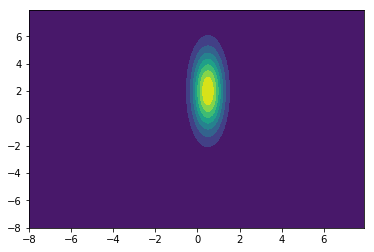

In [402]:
eng, q = sf.Engine(2)

x_ini = 1
p_ini = 1
r = 3
R0 = 1/4
T0 = 1 - R0
theta = np.arccos(np.sqrt(R0))
g0 = np.sqrt(T0/R0)

with eng:
    # prepare the initial states
    Coherent(x_ini/2 + p_ini/2 * 1j) | q[0]  # input (arbite)
    Sgate(r) | q[1] # Ancilla (position squeezed if r>0)
    
    # apply the gates
    BSgate(theta, 0) | (q[0], q[1])  # a 50-50 beamsplitter
    
    # perform the homodyne measurements
    MeasureP | q[1]
    
    # displacement gates conditioned on the measurements
    Zgate(scale(q[1], g0)) | q[0]

state = eng.run('gaussian')
mu, cov = state.reduced_gaussian([0])
x = np.arange(-3*x_ini-5, 3*x_ini+5, 0.1)
p = np.arange(-3*p_ini-5, 3*p_ini+5, 0.1)
W = state.wigner(0, x, p)
X, P = np.meshgrid(x, p)
plt.contourf(X, P, W)

print(mu)
print(cov)

[1. 1.]
[[1. 0.]
 [0. 1.]]


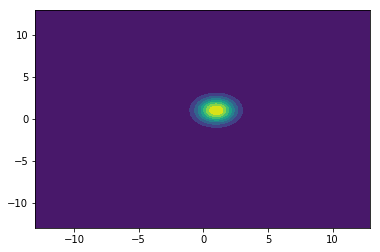

In [394]:
eng, q = sf.Engine(2)

x_ini = 1
p_ini = 1
r = 2
R0 = 0
T0 = 1 - R0
theta = np.arccos(np.sqrt(T0))

with eng:
    # prepare the initial states
    Coherent(x_ini/2 + p_ini/2 * 1j) | q[0]  # input (arbite)
    Sgate(r) | q[1] # Ancilla (position squeezed if r>0)
    
    # apply the gates
    BSgate(0, 0) | (q[0], q[1])  # a 50-50 beamsplitter

state = eng.run('gaussian')
mu, cov = state.reduced_gaussian([0])
x = np.arange(-3*x_ini-10, 3*x_ini+10, 0.1)
p = np.arange(-3*p_ini-10, 3*p_ini+10, 0.1)
W = state.wigner(0, x, p)
X, P = np.meshgrid(x, p)
plt.contourf(X, P, W)

print(mu)
print(cov)

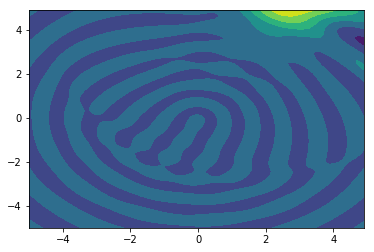

In [222]:
eng, q = sf.Engine(2)

x_ini = 2
p_ini = 2
r = 1
T0 = 1/2
R0 = 1/2
g0 = np.sqrt(T0/R0)
with eng:
    # prepare the initial states
    Coherent(x_ini + p_ini * 1j) | q[0]  # input (arbite)
    Sgate(r) | q[1] # Ancilla (position squeezed if r>0)
    
    # apply the gates
    BSgate(pi/4, 0) | (q[0], q[1])  # a 50-50 beamsplitter
    
    # perform the homodyne measurements
    MeasureP | q[1]
    
    # displacement gates conditioned on the measurements
    Zgate(scale(q[1], g0)) | q[0]

state = eng.run('fock', cutoff_dim=15)
x = np.arange(-5, 5, 0.1)
p = np.arange(-5, 5, 0.1)
W = state.wigner(0, x, p)
X, P = np.meshgrid(x, p)
plt.contourf(X, P, W)


上記を古澤研はループ構造で実現した
- the input pulse is picked up into the loop by setting the beam splitter transmissivity to T(t = 0) = 1
- pulse entering the loop takes time τ to circle around the loop, and is subjected to a phase shift $\hat{R}(\theta_1)$
- After one cycle in the loop, the input pulse coincides with the ancillary squeezed pulse at the beam splitter
- The pulse leaving the loop is then immediately measured by a homodyne detector
- whose output signal is fedforward with gain g0 to the pulse inside the loop
- This feedforward completes the squeezing operation $\hat{S}(−\ln R_0)$
- the pulse in the loop is subjected to another phase shift $\hat{R}(\theta_2)$ and exits the loop by choosing T(2τ) = 1

this loop circuit provides a sufficient set of operations for an arbitrary single-mode Clifford gate in a programmable fashion.

### multi-mode Clifford gates

any n-mode Clif- ford (Gaussian) gate in CVs can be decomposed into  
- a n-mode linear interferometer,  
- followed by the parallel applications of a set of single-mode squeezing operations  
- followed by another n-mode linear interferometer  
(up to displacement operations)


time bin encoding に対する n-mode interferometer が欲しい

An arbitrary n-mode linear interferometer can be decomposed into a sequence of at most $n(n−1)/2$ pairwise beam splitter operations

# 以下、ソースコード確認

In [276]:
eng, q = sf.Engine(2)

x_ini = 0
p_ini = 0
r = 1
T0 = 1/2
R0 = 1/2
g0 = np.sqrt(T0/R0)
with eng:
    # prepare the initial states
    Coherent(x_ini + p_ini * 1j) | q[0]  # input (arbite)
    Sgate(r) | q[1] # Ancilla (position squeezed if r>0)
    
    # apply the gates
    BSgate(pi/4, 0) | (q[0], q[1])  # a 50-50 beamsplitter


state = eng.run('gaussian')
mu1, cov1 = state.reduced_gaussian([0])
mu2, cov2 = state.reduced_gaussian([1])

print(mu1, mu2)
print(cov1, cov2)

[0. 0.] [0. 0.]
[[0.56766764 0.        ]
 [0.         4.19452805]] [[0.56766764 0.        ]
 [0.         4.19452805]]


In [278]:
# Coherent state
mean1 = np.zeros(2)
x_ini = 0
p_ini = 0
beta = [x_ini, p_ini]
mean1 += beta

The class is initialized by providing an integer indicating the number of modes.  
        Unlike the "standard" covariance matrix for the Wigner function that uses symmetric ordering
        as defined in e.g.  
        [1] Gaussian quantum information
        Christian Weedbrook, Stefano Pirandola, Raúl García-Patrón, Nicolas J. Cerf, Timothy C. Ralph, Jeffrey H. Shapiro, and Seth Lloyd
        Rev. Mod. Phys. 84, 621 – Published 1 May 2012  
        we define covariance matrices in terms of the following two quantities:
        $$
        N_{i,j} =\langle a_i^\dagger a_j \rangle
        M_{i,j} = \langle a_i a_j \rangle
        $$
        Note that the matrix $N$ is hermitian and the matrix M is symmetric.
        The mean displacements are stored as expectation values of the destruction operator $\alpha_i  = \langle a_i \rangle$
        We also provide functions that give the symmetric ordered covariance matrices and the mean displacement for the quadrature
        operators $q = a+a^\dagger$ and $p = i(a^\dagger -a)$. Note that with these conventions $[q,p]=2 i$.
        For vacuum one has $N_{i,j}=M_{i,j}=\alpha_i =0$,
        The quantities $N,M,\alpha$ are stored in the variable nmat, mmat, mean respectively

In [ ]:
# squeezing
r = 1
phi = 0
k = 0
z = r*exp(1j*phi)
nlen = 3
nmat = np.zeros((nlen, nlen), dtype=complex)
mmat = np.zeros((nlen, nlen), dtype=complex)

phase = np.exp(1j*phi)
phase2 = phase*phase
sh = np.sinh(r)
ch = np.cosh(r)
sh2 = sh*sh
ch2 = ch*ch
shch = sh*ch

nk = np.copy(nmat[k]) # k's row
mk = np.copy(mmat[k])
alphak = np.copy(self.mean[k])

# Update displacement of mode k
self.mean[k] = alphak*ch - phase*np.conj(alphak)*sh

# First update the diagonal elements
self.nmat[k, k] = sh2 - phase*shch*np.conj(mk[k]) - shch*np.conj(phase)*mk[k] + ch2*nk[k] + sh2*nk[k]
self.mmat[k, k] = -(phase*shch) + phase2*sh2*np.conj(mk[k]) + ch2*mk[k] - 2*phase*shch*nk[k]

# Update the column k
for l in np.delete(np.arange(self.nlen), k):
    self.nmat[k, l] = -(sh*np.conj(phase)*mk[l]) + ch*nk[l]
    self.mmat[k, l] = ch*mk[l] - phase*sh*nk[l]
    


In [290]:
np.ndarray( [[0, 1], [2, 3]] )

TypeError: 'list' object cannot be interpreted as an integer